<a href="https://colab.research.google.com/github/Aadhavan-27/vancomycin-dose-prediction/blob/main/CAPSTONE_FINAL_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

VANCOMYCIN TROUGH CONCENTRATION PREDICTION

1. Loading Data...
   Dataset shape: (500, 13)
   Features: 12, Target: trough_concentration

2. Splitting data into train and test sets...
   Training set: 400 samples
   Test set: 100 samples

3. Scaling features...
   ✓ Features standardized

4. Training Models...

   a) Random Forest
      Training R²: 0.9140
      Test R²: 0.6972
      Test RMSE: 2.2368
      Test MAE: 1.8558

   b) XGBoost
      Training R²: 0.9968
      Test R²: 0.6636
      Test RMSE: 2.3577
      Test MAE: 1.9165

5. Model Comparison:
               train_r2  test_r2  train_rmse  test_rmse  train_mae  test_mae
Random Forest    0.9140   0.6972      1.0644     2.2368     0.8107    1.8558
XGBoost          0.9968   0.6636      0.2063     2.3577     0.1533    1.9165

   ✓ Best Model: Random Forest
     Test R²: 0.6972
     Test RMSE: 2.2368

6. Feature Importance Analysis:

   Random Forest Top 5 Features:
      dose: 0.5053
      crcl: 0.2276
      age: 0.0564
      time

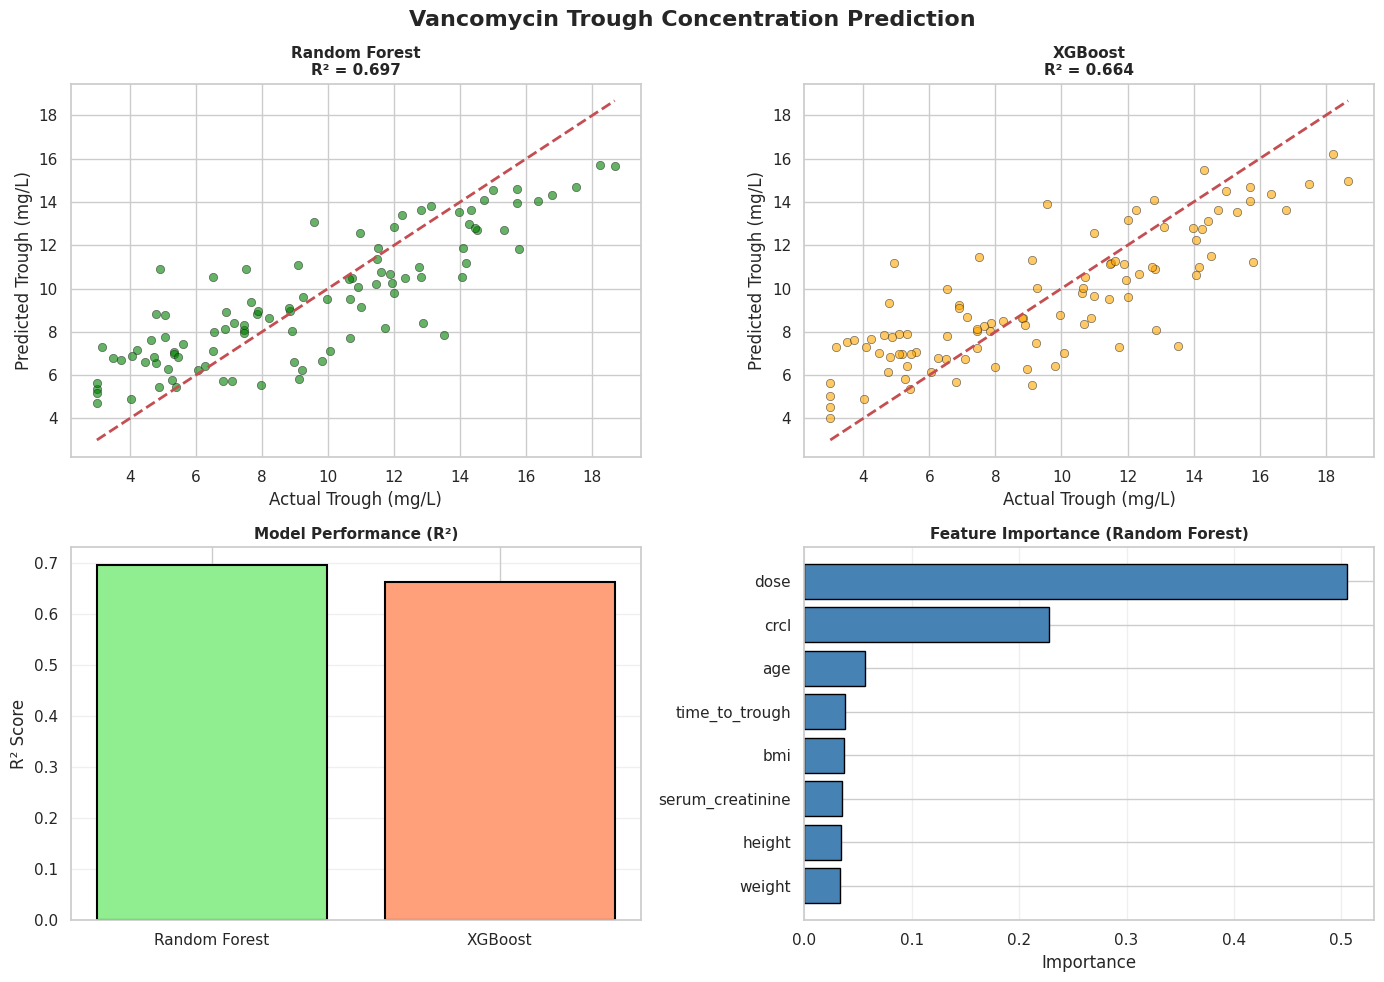


8. Example Prediction:

   Predicted Trough Concentrations:
      Random Forest: 9.51 mg/L
      XGBoost: 9.45 mg/L
      Prediction: 9.48 mg/L

ANALYSIS COMPLETE!


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# ============================================================================
# 1. DATA GENERATION (Replace this with your actual dataset)
# ============================================================================
def generate_synthetic_vancomycin_data(n_samples=500):
    data = {
        'age': np.random.randint(18, 90, n_samples),
        'weight': np.random.normal(70, 15, n_samples),
        'height': np.random.normal(170, 10, n_samples),
        'gender': np.random.choice([0, 1], n_samples),  # 0=Female, 1=Male
        'serum_creatinine': np.random.uniform(0.5, 3.0, n_samples),
        'dose': np.random.choice([500, 750, 1000, 1250, 1500], n_samples),
        'dosing_interval': np.random.choice([8, 12, 24], n_samples),
        'duration_of_infusion': np.random.choice([1, 1.5, 2], n_samples),
        'time_to_trough': np.random.uniform(0.5, 2, n_samples),
    }

    df = pd.DataFrame(data)

    # Derived features
    df['bmi'] = df['weight'] / ((df['height']/100) ** 2)
    df['daily_dose'] = (df['dose'] * 24) / df['dosing_interval']

    # Calculate CrCl (Cockcroft-Gault)
    df['crcl'] = ((140 - df['age']) * df['weight']) / (72 * df['serum_creatinine'])
    df.loc[df['gender'] == 0, 'crcl'] *= 0.85  # Female adjustment

    # Generate synthetic trough concentrations
    trough = (
        5 +
        (df['dose'] / 100) * 0.8 -
        (df['weight'] / 10) * 0.3 -
        (df['crcl'] / 10) * 0.4 +
        (df['age'] / 10) * 0.2 +
        np.random.normal(0, 2, n_samples)
    )

    df['trough_concentration'] = np.clip(trough, 3, 35)
    return df


print("=" * 80)
print("VANCOMYCIN TROUGH CONCENTRATION PREDICTION")
print("=" * 80)

print("\n1. Loading Data...")
df = generate_synthetic_vancomycin_data(500)
print(f"   Dataset shape: {df.shape}")
print(f"   Features: {df.shape[1] - 1}, Target: trough_concentration")

# ============================================================================
# 2. FEATURE SELECTION
# ============================================================================
feature_columns = [
    'age', 'weight', 'height', 'gender', 'serum_creatinine',
    'dose', 'dosing_interval', 'duration_of_infusion',
    'time_to_trough', 'bmi', 'daily_dose', 'crcl'
]

X = df[feature_columns]
y = df['trough_concentration']

# ============================================================================
# 3. TRAIN-TEST SPLIT
# ============================================================================
print("\n2. Splitting data into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"   Training set: {X_train.shape[0]} samples")
print(f"   Test set: {X_test.shape[0]} samples")

# ============================================================================
# 4. FEATURE SCALING
# ============================================================================
print("\n3. Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("   ✓ Features standardized")

# ============================================================================
# 5. MODEL TRAINING
# ============================================================================
print("\n4. Training Models...")
print("=" * 80)

models = {}
results = {}

# ---------------------- Random Forest ----------------------
print("\n   a) Random Forest")
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
models['Random Forest'] = rf

# Predictions
y_pred_train_rf = rf.predict(X_train)
y_pred_test_rf = rf.predict(X_test)

# Metrics
results['Random Forest'] = {
    'train_r2': r2_score(y_train, y_pred_train_rf),
    'test_r2': r2_score(y_test, y_pred_test_rf),
    'train_rmse': np.sqrt(mean_squared_error(y_train, y_pred_train_rf)),
    'test_rmse': np.sqrt(mean_squared_error(y_test, y_pred_test_rf)),
    'train_mae': mean_absolute_error(y_train, y_pred_train_rf),
    'test_mae': mean_absolute_error(y_test, y_pred_test_rf)
}

print(f"      Training R²: {results['Random Forest']['train_r2']:.4f}")
print(f"      Test R²: {results['Random Forest']['test_r2']:.4f}")
print(f"      Test RMSE: {results['Random Forest']['test_rmse']:.4f}")
print(f"      Test MAE: {results['Random Forest']['test_mae']:.4f}")

# ---------------------- XGBoost ----------------------
print("\n   b) XGBoost")
xgb = XGBRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train, y_train)
models['XGBoost'] = xgb

# Predictions
y_pred_train_xgb = xgb.predict(X_train)
y_pred_test_xgb = xgb.predict(X_test)

# Metrics
results['XGBoost'] = {
    'train_r2': r2_score(y_train, y_pred_train_xgb),
    'test_r2': r2_score(y_test, y_pred_test_xgb),
    'train_rmse': np.sqrt(mean_squared_error(y_train, y_pred_train_xgb)),
    'test_rmse': np.sqrt(mean_squared_error(y_test, y_pred_test_xgb)),
    'train_mae': mean_absolute_error(y_train, y_pred_train_xgb),
    'test_mae': mean_absolute_error(y_test, y_pred_test_xgb)
}

print(f"      Training R²: {results['XGBoost']['train_r2']:.4f}")
print(f"      Test R²: {results['XGBoost']['test_r2']:.4f}")
print(f"      Test RMSE: {results['XGBoost']['test_rmse']:.4f}")
print(f"      Test MAE: {results['XGBoost']['test_mae']:.4f}")

# ============================================================================
# 6. MODEL COMPARISON
# ============================================================================
print("\n5. Model Comparison:")
print("=" * 80)
comparison_df = pd.DataFrame(results).T
print(comparison_df.round(4))

best_model_name = comparison_df['test_r2'].idxmax()
print(f"\n   ✓ Best Model: {best_model_name}")
print(f"     Test R²: {comparison_df.loc[best_model_name, 'test_r2']:.4f}")
print(f"     Test RMSE: {comparison_df.loc[best_model_name, 'test_rmse']:.4f}")

# ============================================================================
# 7. FEATURE IMPORTANCE
# ============================================================================
print("\n6. Feature Importance Analysis:")
print("=" * 80)

rf_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

xgb_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': xgb.feature_importances_
}).sort_values('importance', ascending=False)

print("\n   Random Forest Top 5 Features:")
for idx, row in rf_importance.head(5).iterrows():
    print(f"      {row['feature']}: {row['importance']:.4f}")

print("\n   XGBoost Top 5 Features:")
for idx, row in xgb_importance.head(5).iterrows():
    print(f"      {row['feature']}: {row['importance']:.4f}")

# ============================================================================
# 8. VISUALIZATION
# ============================================================================
print("\n7. Generating Visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Vancomycin Trough Concentration Prediction', fontsize=16, fontweight='bold')

# Plot 1: Random Forest - Actual vs Predicted
axes[0, 0].scatter(y_test, y_pred_test_rf, alpha=0.6, edgecolors='k', linewidth=0.5, color='green')
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_title(f'Random Forest\nR² = {results["Random Forest"]["test_r2"]:.3f}', fontsize=11, fontweight='bold')
axes[0, 0].set_xlabel('Actual Trough (mg/L)')
axes[0, 0].set_ylabel('Predicted Trough (mg/L)')

# Plot 2: XGBoost - Actual vs Predicted
axes[0, 1].scatter(y_test, y_pred_test_xgb, alpha=0.6, edgecolors='k', linewidth=0.5, color='orange')
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 1].set_title(f'XGBoost\nR² = {results["XGBoost"]["test_r2"]:.3f}', fontsize=11, fontweight='bold')
axes[0, 1].set_xlabel('Actual Trough (mg/L)')
axes[0, 1].set_ylabel('Predicted Trough (mg/L)')

# Plot 3: Model Performance Comparison (R²)
model_names = list(results.keys())
r2_scores = [results[m]['test_r2'] for m in model_names]
colors = ['lightgreen', 'lightsalmon']
bars = axes[1, 0].bar(model_names, r2_scores, color=colors, edgecolor='black', linewidth=1.5)
axes[1, 0].set_ylabel('R² Score')
axes[1, 0].set_title('Model Performance (R²)', fontsize=11, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Plot 4: Feature Importance (Random Forest)
top_features = rf_importance.head(8)
axes[1, 1].barh(top_features['feature'], top_features['importance'], color='steelblue', edgecolor='black')
axes[1, 1].set_xlabel('Importance')
axes[1, 1].set_title('Feature Importance (Random Forest)', fontsize=11, fontweight='bold')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('vancomycin_rf_xgb_comparison.png', dpi=300, bbox_inches='tight')
print("   ✓ Saved: vancomycin_rf_xgb_comparison.png")
plt.show()

# ============================================================================
# 9. EXAMPLE PREDICTION
# ============================================================================
print("\n8. Example Prediction:")
print("=" * 80)

sample_patient = pd.DataFrame({
    'age': [65],
    'weight': [75],
    'height': [170],
    'gender': [1],
    'serum_creatinine': [1.2],
    'dose': [1000],
    'dosing_interval': [12],
    'duration_of_infusion': [1.5],
    'time_to_trough': [1.0],
    'bmi': [75 / (1.70 ** 2)],
    'daily_dose': [(1000 * 24) / 12],
    'crcl': [((140 - 65) * 75) / (72 * 1.2)]
})

sample_scaled = scaler.transform(sample_patient)
pred_rf = rf.predict(sample_patient)[0]
pred_xgb = xgb.predict(sample_patient)[0]
avg_pred = np.mean([pred_rf, pred_xgb])

print("\n   Predicted Trough Concentrations:")
print(f"      Random Forest: {pred_rf:.2f} mg/L")
print(f"      XGBoost: {pred_xgb:.2f} mg/L")
print(f"      Prediction: {avg_pred:.2f} mg/L")

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE!")
print("=" * 80)
